# Audience Quantity of Motion Averages, MusicLab Copenhagen


Generation of plots for Audience Motion paper, Average quantity of motion per event and event type, repeated measures ANOVAs and pairwise comparisons

In [1]:
import sys
import os
import time

import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d
import matplotlib.cm as cm
import pingouin as pg

import matplotlib.gridspec as gridspec

In [5]:
# import functions from definition files in the same folder as this jupiter notebook
%load_ext autoreload
%autoreload 1
%aimport am

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
%reload_ext autoreload

In [7]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

# Data preparation 
Aligning cellphone accelerometer measurements collected via MusicLab App and AX3 measurements from audience participant was performed in a different repository. This process depended on the detection of taps by participants on their devices to the synchronisation cues played before each half of the concert. See Notebook below for a summary of that work to align accelerometer measurements: 
https://github.com/finn42/MusicLabCopenhegan_MotionAlignment/blob/main/Alignment_Describe.ipynb

These aligned accelerometer measurments were released publically as part of the MusicLab Copenhagen repository (https://osf.io/v9wa4/). This analysis uses the fullowing published datasets from this study:

  1. Aligned accelerometer measurements from each audience member: https://osf.io/9qeg6/
  2. Participants' survey responses: https://osf.io/89s5w/ 
  3. Anonimised seating information for in hall participants: https://osf.io/8t4rz/ ./Participants/Near_Participants_Hall.csv (https://osf.io/c5zgf)
  4. Concert event timing information:  https://osf.io/8t4rz/ ./Timing/Events_Main.csv

In [8]:
general_loc = '../'

public_mlmotion = general_loc + 'Public_data/Motion_ML/'
public_ax3 = general_loc +  'Public_data/Motion_AX3/'
public_Part = general_loc + 'Public_data/Participants/'
public_time = general_loc + 'Public_data/Timing/'

In [9]:
internal_Part = general_loc + 'Participants_internal/'

In [10]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)


In [11]:
# concert times 10 Hz
ts_ct = np.arange(-1086,9715, 0.1)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')


In [12]:
concert_times = pd.read_csv(public_time +'Events_Main_Segments.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format

concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('Datetime')

In [13]:
evord = ['Beethoven', 'Schnittke', 'Bach', 'Folk', 'Survey','Speech', 'Clapping']
Main_concert_times['Sections']=''
for ev in evord:
    Main_concert_times.loc[Main_concert_times['Event'].str.startswith(ev[:4]),'Sections'] = ev

Main_concert_times.iloc[:10,:]

,Time_s,Time_ms,Event,Event_Type,Time_Stream,Event_Duration,Shorter_tag,sequence,Sections
Datetime,,,,,,,,,
2021-10-26 17:36:35,-691.24,-691240,Clapping for MC,Applause,946.000,18.12,Claps 0,0,Clapping
2021-10-26 17:36:53,-673.12,-673120,Speech,Speech,964.120,117.08,Speech 1,1,Speech
2021-10-26 17:38:50,-556.04,-556040,Clapping for MC,Applause,1081.200,5.88,Claps 1,2,Clapping
2021-10-26 17:38:59,-547.16,-547160,Speech MC1,Speech,1090.080,377.52,Speech 2,3,Speech
2021-10-26 17:45:16,-169.64,-169640,Clapping for MC,Applause,1467.600,1.05,Claps 1.1,4,Clapping
2021-10-26 17:45:17,-167.59,-167590,Speech MC2,Speech,1468.799,140.96,Speech 3,5,Speech
2021-10-26 17:47:39,-27.50,-27500,preTaps 1,Synchronisation,1609.740,27.50,preSynch 1,6,
2021-10-26 17:48:06,0.00,0,Taps 1,Synchronisation,1637.240,14.38,Synch 1,7,
2021-10-26 17:48:20,14.38,14380,Clapping in Musicians,Applause,1651.620,43.02,Claps 2,8,Clapping


In [14]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
part_det_columns = ['Participant_Code','Attendance', 'Motion_Quality', 'Seat_Zone','Watch_Alone']
# need only in person participants with aligned motion traces
partDets = partDets.loc[partDets['Attendance'].isin(['A','B']),part_det_columns] # in person hall participant
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
alignedParts.iloc[:5,:]

,Participant_Code,Attendance,Motion_Quality,Seat_Zone,Watch_Alone
0,ADQ001,A,Q,6.0,0.0
1,ADQ002,A,Q,3.0,0.0
2,ADQ003,A,Q,2.0,0.0
3,ADQ004,A,Q,4.0,1.0
4,ADQ005,A,Q,4.0,0.0


Retrieve audience motion time series from previous extraction

In [15]:
aud_df = pd.read_csv('./data/essential/Audience_10Hz_sampled.csv',index_col=0)
aud_df.index = (ts_ct/1000).round(1)
ori_aud_df = aud_df.copy()

In [16]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
part_det_columns = ['Participant_Code','Attendance', 'Motion_Quality', 'Seat_Zone','Watch_Alone']
partDets = partDets.loc[partDets['Attendance'].isin(['A','B']),part_det_columns] # in person hall participant
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
alignedParts.iloc[:5,:]

,Participant_Code,Attendance,Motion_Quality,Seat_Zone,Watch_Alone
0,ADQ001,A,Q,6.0,0.0
1,ADQ002,A,Q,3.0,0.0
2,ADQ003,A,Q,2.0,0.0
3,ADQ004,A,Q,4.0,1.0
4,ADQ005,A,Q,4.0,0.0


In [17]:
#aligned_Part_Codes[:85], aligned_Part_Codes[85:]
AUD = aud_df.loc[:,aligned_Part_Codes[:85]].copy()
AUD['Virtual'] = np.nan
AUD['Virtual.'] = np.nan
AUD['Virtual..'] = np.nan
AUD['Virtual...'] = np.nan
AUD['Virtual....'] = np.nan
AUD = pd.concat([AUD,aud_df.loc[:,aligned_Part_Codes[85:]].copy()],axis=1)
int_start = Main_concert_times.query('Event=="Interval"')['Time_s'].iloc[0]
int_end = int_start+Main_concert_times.query('Event=="Interval"')['Event_Duration'].iloc[0]
AUD.loc[int_start:int_end,:]= np.nan

In [18]:
ETypes = ['Music','Survey','Speech','Applause']
minDur = 60 # s
MTs = Main_concert_times.query('Event_Type in @ETypes and Event_Duration > @minDur')


[-691.24, 8352.060000000001]


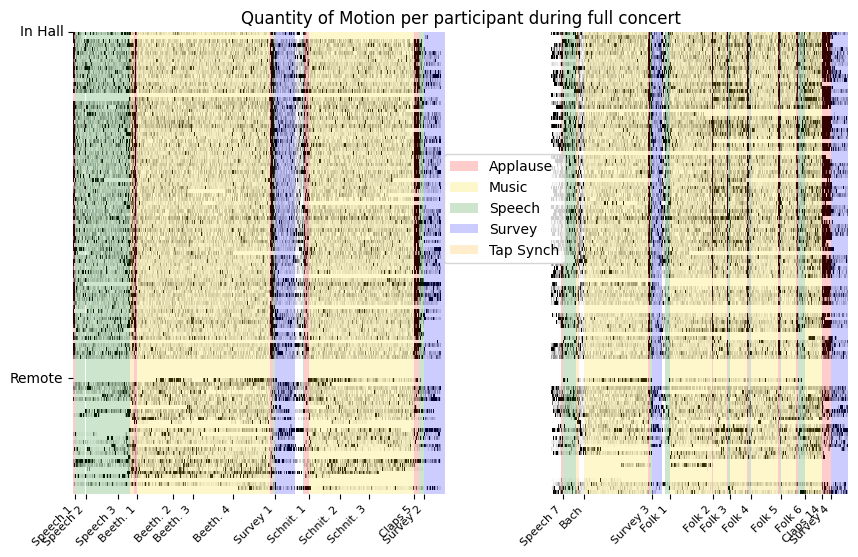

In [19]:
seg_start = concert_times.iloc[0,:].Time_s #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = concert_times.iloc[53,:].Time_s + 200
print([seg_start,seg_end])
Event_Pallet={'Applause':'red','Music':'gold','Speech':'green','Survey':'blue','Synch':'purple'}
alpha_factor = 0.2

seg_df = AUD.loc[seg_start:seg_end].copy()
seg_df = seg_df.fillna(0)

fig, (ax1) = plt.subplots(1, 1,figsize = [10,6])
chart = sns.heatmap(data=-seg_df.transpose(), ax=ax1,vmin=-0.5, vmax=0,cbar=False, cmap=cm.gray)

seg_times = Main_concert_times.query('Event_Type in @ETypes and Event_Duration > @minDur')
new_xticks = len(seg_df)*(seg_times['Time_s'] - seg_start)/(seg_end -seg_start)
plt.xticks(new_xticks,seg_times.Shorter_tag, fontsize=8, ha='right')
ax1.tick_params(axis='x', labelrotation=45)

# marking events by colour panel
seg_times = concert_times
new_xticks = len(seg_df)*(seg_times['Time_s'] - seg_start)/(seg_end -seg_start)
new_dur = len(seg_df)*(seg_times['Event_Duration'])/(seg_end -seg_start)
xrange = [0,180]

ax1.margins(0)
ax1.axvspan(seg_start,xrange[0],0,1, facecolor='red',label="Applause",alpha=alpha_factor)
ax1.axvspan(seg_start,xrange[0],0,1,  facecolor='gold',label="Music",alpha=alpha_factor)
ax1.axvspan(seg_start,xrange[0],0,1, facecolor='green',label="Speech",alpha=alpha_factor)
ax1.axvspan(seg_start,xrange[0],0,1, facecolor='blue',label="Survey",alpha=alpha_factor)
ax1.axvspan(seg_start,xrange[0],0,1, facecolor='orange',label="Tap Synch",alpha=alpha_factor)

ax1.legend(loc='upper left', bbox_to_anchor=(0.47,0.75))


yrange = [0,120.0]
for i,r in seg_times.iterrows():
    ei = new_xticks[i]
    ej = new_xticks[i] + new_dur[i]
    if r['Event_Type'].startswith('Applause'):
        ax1.axvspan(ei, ej,yrange[0],yrange[1], facecolor='red', alpha=alpha_factor)
    if r['Event_Type'].startswith('Musi'):
        ax1.axvspan(ei, ej,yrange[0],yrange[1], facecolor='gold', alpha=alpha_factor)
    if r['Event_Type'].endswith('Speech'):
        ax1.axvspan(ei, ej,yrange[0],yrange[1], facecolor='green', alpha=alpha_factor)
    if r['Event_Type'].startswith('Survey'):
        ax1.axvspan(ei, ej,yrange[0],yrange[1], facecolor='blue', alpha=alpha_factor)
    if r['Event_Type'].startswith('Synch'):
        ax1.axvspan(ei, ej,yrange[0],yrange[1], facecolor='orange', alpha=alpha_factor)

ax1.set_yticks([0,90])
ax1.set_yticklabels(['In Hall','Remote'])
plt.title('Quantity of Motion per participant during full concert')
plt.savefig('./plots/qom_n_full_colour.png', bbox_inches = 'tight',dpi = 196)
plt.show()


In [20]:
concert_times['Event_Type'].unique()

array(['Applause', 'Speech', 'Synchronisation', 'Music', 'Survey',
       'Interval', 'End'], dtype=object)

[-691.24, 8352.060000000001]


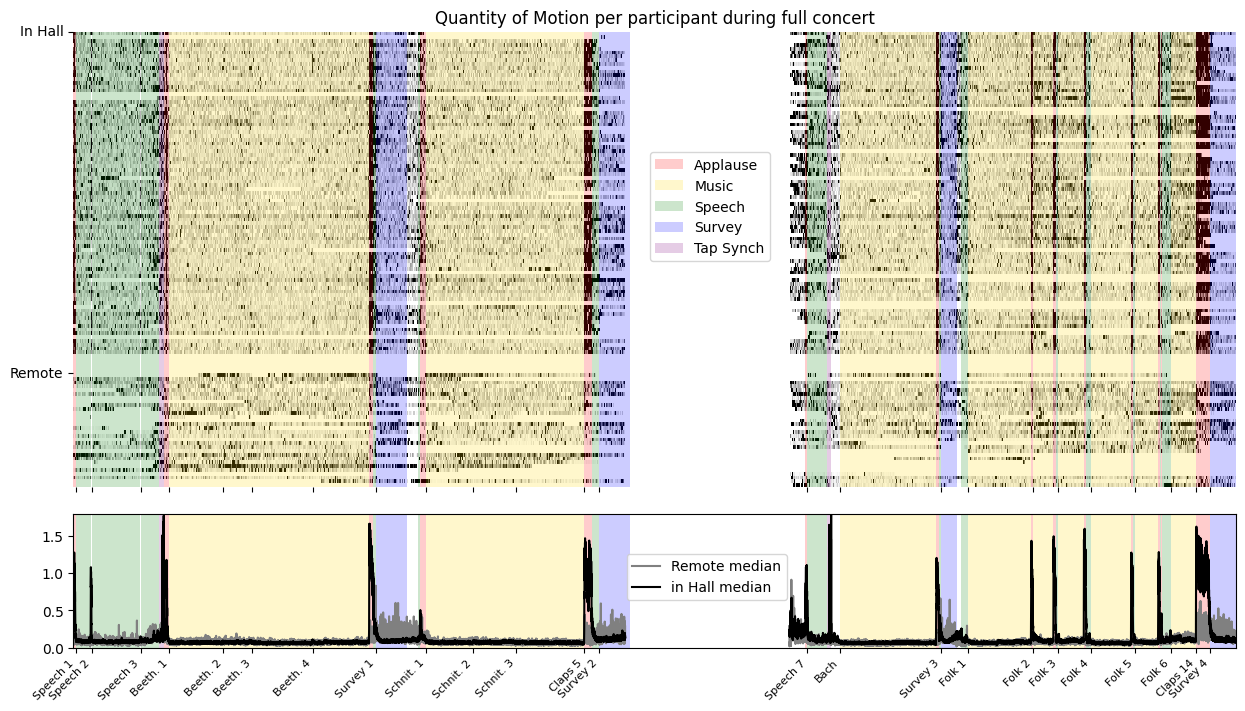

In [21]:
seg_start = concert_times.iloc[0,:].Time_s #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = concert_times.iloc[53,:].Time_s + 200
print([seg_start,seg_end])
Event_Pallet={'Applause':'red','Music':'gold','Speech':'green','Survey':'blue','Synchronisation':'purple'}
ETypes_ext = ['Music', 'Survey', 'Speech', 'Applause','Synchronisation']
alpha_factor = 0.2
# seg_times = Main_concert_times.copy()
seg_df = AUD.loc[seg_start:seg_end].copy()
seg_df = seg_df.fillna(0)

fig = plt.figure(figsize=(15,8))
ax1 = plt.subplot2grid((4,1),(0,0), colspan=1, rowspan=3)

chart = sns.heatmap(data=-seg_df.transpose(), ax=ax1,vmin=-0.5, vmax=0,cbar=False, cmap=cm.gray)

seg_times = Main_concert_times.query('Event_Type in @ETypes and Event_Duration > @minDur')
xticks=seg_times['Time_s'] 
new_xticks = len(seg_df)*(seg_times['Time_s'] - seg_start)/(seg_end -seg_start)
ndur = seg_times['Event_Duration']
new_dur = len(seg_df)*(seg_times['Event_Duration'])/(seg_end -seg_start)

plt.xticks(new_xticks)
xrange = [0,180]

ax1.margins(0)
ax1.axvspan(seg_start,xrange[0],0,1, facecolor='red',label="Applause",alpha=alpha_factor)
ax1.axvspan(seg_start,xrange[0],0,1,  facecolor='gold',label="Music",alpha=alpha_factor)
ax1.axvspan(seg_start,xrange[0],0,1, facecolor='green',label="Speech",alpha=alpha_factor)
ax1.axvspan(seg_start,xrange[0],0,1, facecolor='blue',label="Survey",alpha=alpha_factor)
ax1.axvspan(seg_start,xrange[0],0,1, facecolor='purple',label="Tap Synch",alpha=alpha_factor)

ax1.legend(loc='upper left', bbox_to_anchor=(0.49,0.75))

ax2 = plt.subplot2grid((4,1),(3,0), colspan=1, rowspan=1)
AUD.loc[:,aligned_Part_Codes[85:]].median(axis=1).plot(ax=ax2,c='grey',label='Remote median')                       
AUD.loc[:,aligned_Part_Codes[:85]].median(axis=1).plot(ax=ax2,c='k',label='in Hall median')  
ax2.legend(loc='upper left', bbox_to_anchor=(0.47,0.75))

ax1.set_yticks([0,90])
ax1.set_yticklabels(['In Hall','Remote'])
ax1.set_title('Quantity of Motion per participant during full concert')
                       
ax2.set_xticks(xticks,seg_times.Shorter_tag, fontsize=8, ha='right')
ax2.tick_params(axis='x', labelrotation=45)    

ax2.set_xlim([seg_start,seg_end])
ax2.set_ylim([0,1.8])

yrange = [0,120.0]
yrange2 = [0,2.0]
seg_times = concert_times.loc[concert_times['Event_Type'].isin(ETypes_ext)]
new_xticks = (len(seg_df)*(seg_times['Time_s'] - seg_start)/(seg_end -seg_start)).values
new_dur = (len(seg_df)*(seg_times['Event_Duration'])/(seg_end -seg_start)).values
xticks=seg_times['Time_s'].values
ndur = seg_times['Event_Duration'].values
for i in range(len(seg_times)):
    r = seg_times.iloc[i,:]
    for evs in ETypes_ext:
        if r['Event_Type'].startswith(evs[:4]):
            ax1.axvspan(new_xticks[i], new_xticks[i] + new_dur[i],yrange[0],yrange[1], facecolor=Event_Pallet[evs], alpha=alpha_factor)
            ax2.axvspan(xticks[i], xticks[i] + ndur[i],yrange2[0],yrange2[1], facecolor=Event_Pallet[evs], alpha=alpha_factor)

plt.savefig('./plots/qom_n_full_colour_wide.png', bbox_inches = 'tight',dpi = 196)
plt.show()


# Scaling, segmentation and preliminary analysis
using 50 Hz sampled measurements.

In [22]:
aud_df.index = dt_ct        
ori_aud_df = aud_df.copy()
ori_aud_df.index = (ts_ct/1000).round(1)


In [23]:
ori_aud_df.iloc[:5,:]

,ADQ001,ADQ002,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,...,BEQ113,BEQ114,BEQ115,BEQ116,BEQ117,BEQ118,BEQ119,BnQ131,BnQ132,BnQ133
-1086.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1085.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1085.8,0.740777,0.467856,0.212834,0.101379,0.234912,0.224302,0.486310,0.064859,0.247404,0.237059,...,0.032345,NaN,NaN,NaN,NaN,0.227207,NaN,NaN,NaN,NaN
-1085.7,0.691307,0.179505,0.349901,0.100000,0.249657,0.184666,0.597926,0.055355,0.543207,0.371191,...,0.010653,NaN,NaN,NaN,NaN,0.183257,NaN,NaN,NaN,NaN
-1085.6,0.711500,0.137325,0.154668,0.063158,0.181522,0.134561,0.456580,0.072090,0.082915,1.156659,...,0.017225,NaN,NaN,NaN,NaN,0.140195,NaN,NaN,NaN,NaN


In [24]:
minDur=60

In [25]:
ev_tags = ['Beethoven','Schnittke','Bach','Folk','Survey','Speech','Clapping']
df = pd.DataFrame(index = ev_tags,columns = ori_aud_df.columns)
for ev_tag in ev_tags:
    MTs = Main_concert_times.query('Sections==@ev_tag and Event_Duration > @minDur')
    sigs = []
    for i,r in MTs.iterrows():
         sigs.append(ori_aud_df.loc[r['Time_s']:r['Time_s']+r['Event_Duration'],:].copy())
    fullset = pd.concat(sigs,axis=0)
    df.loc[ev_tag,:] = fullset.mean()
df

,ADQ001,ADQ002,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,...,BEQ113,BEQ114,BEQ115,BEQ116,BEQ117,BEQ118,BEQ119,BnQ131,BnQ132,BnQ133
Beethoven,0.069311,NaN,0.094418,0.101837,0.07339,0.108468,0.079436,0.086562,0.078947,0.132908,...,0.050851,0.209203,0.106644,0.164509,0.342741,0.182293,NaN,0.084129,0.272131,NaN
Schnittke,NaN,NaN,0.09243,0.143013,0.08211,0.1171,0.071236,0.08482,0.083305,0.106298,...,NaN,0.324734,0.160088,0.174884,0.288465,0.168656,NaN,NaN,0.142764,NaN
Bach,0.056344,0.135229,0.095909,0.124146,0.076237,0.103214,0.072805,0.075133,0.063821,0.103792,...,NaN,NaN,0.161927,NaN,NaN,NaN,0.041645,0.080859,0.044488,0.064046
Folk,0.090395,0.110848,0.12164,0.16044,0.102084,0.103741,0.122425,0.108638,0.077485,0.166454,...,0.13115,NaN,0.31208,1.033047,NaN,NaN,NaN,0.099888,0.068717,0.11593
Survey,0.209239,0.276741,0.138638,0.390651,0.154346,0.20982,0.193861,0.116464,0.160078,0.598902,...,2.63744,0.300593,NaN,0.21808,0.455517,NaN,NaN,0.257953,0.263718,0.225292
Speech,0.243846,0.260689,0.292195,0.282486,0.119624,0.197578,0.113814,0.125161,0.123116,0.33074,...,0.561393,0.507103,0.117763,0.797485,1.385634,0.3095,0.02373,0.159163,0.465619,0.162762
Clapping,0.903431,1.050359,1.149658,1.383438,0.679812,1.88919,1.528213,1.328942,1.003264,1.406358,...,0.428255,0.739514,0.957739,0.021591,NaN,NaN,NaN,0.331674,0.277735,0.421537


In [26]:
mu = df.loc['Speech',df.columns.str.startswith('A')].median()
#scalling factor, just for simplicity of plotting. 
mu

0.16076200730852108

In [27]:
ev_tags = ['Beethoven','Schnittke','Bach','Folk','Survey','Speech','Clapping']
df = pd.DataFrame(index = ev_tags,columns = ori_aud_df.columns)
for ev_tag in ev_tags:
    MTs = Main_concert_times.query('Sections==@ev_tag and Event_Duration > @minDur')
    sigs = []
    for i,r in MTs.iterrows():
         sigs.append(ori_aud_df.loc[r['Time_s']:r['Time_s']+r['Event_Duration'],:].copy())
    fullset = pd.concat(sigs,axis=0)
    df.loc[ev_tag,:] = fullset.mean()
results = df.loc[:,df.columns.str.startswith('A')].copy()/mu
res1 = pd.melt(results.transpose(),var_name = 'Event',value_name ='Quantity of Movement (QoM)',ignore_index=False)
res1.reset_index(inplace=True)
res1['Sections'] = 'Music'
ev_tags = ['Survey','Speech','Clapping']
for ev_tag in ev_tags: res1.loc[res1['Event'].str.startswith(ev_tag[:4]),'Sections']=ev_tag

In [28]:
ev_tags = ['Music']
df = pd.DataFrame(index = ev_tags,columns = ori_aud_df.columns)
for ev_tag in ev_tags:
    MTs = Main_concert_times.query('Event_Type==@ev_tag and Event_Duration > @minDur')
    for i,r in MTs.iterrows():
        if r['Event_Duration']> minDur:
            sigs = ori_aud_df.loc[r['Time_s']:r['Time_s']+r['Event_Duration'],:]
            df.loc[r['Shorter_tag'],:] = sigs.mean()

# inhall only,scaled for plotting
results = df.loc[:,df.columns.str.startswith('A')].copy()/mu
res2 = pd.melt(results.transpose(),var_name = 'Event',value_name ='Quantity of Movement (QoM)',ignore_index=False)
res2.reset_index(inplace=True)
res2['Sections'] = 'Music'

In [29]:
ev_tags = ['Survey','Speech','Applause']
Segs = []
for ev_tag in ev_tags: Segs.append(Main_concert_times.query('Event_Type==@ev_tag and Event_Duration > @minDur'))
MTs = pd.concat(Segs,axis=0)

ev_tags = MTs['Shorter_tag']
df = pd.DataFrame(index = ev_tags,columns = ori_aud_df.columns)
for i,r in MTs.iterrows():
    sigs=ori_aud_df.loc[r['Time_s']:r['Time_s']+r['Event_Duration'],:].copy()
    df.loc[r['Shorter_tag'],:] = sigs.mean()

# inhall only,scaled for plotting
results = df.loc[:,df.columns.str.startswith('A')].copy()/mu
print(results.index)
res3 = pd.melt(results.transpose(),var_name = 'Event',value_name ='Quantity of Movement (QoM)',ignore_index=False)
res3.reset_index(inplace=True)
res3['Sections'] = ''
ev_tags = ['Survey','Speech','Clapping']
for ev_tag in ev_tags: res3.loc[res3['Event'].str.startswith(ev_tag[:4]),'Sections']=ev_tag

Index(['Survey 1', 'Survey 2', 'Survey 3', 'Survey 4', 'Speech 1', 'Speech 2',
       'Speech 3', 'Speech 7', 'Claps 5', 'Claps 14'],
      dtype='object', name='Shorter_tag')


In [30]:
musord = ['Survey 1', 'Survey 2', 'Survey 3', 'Survey 4','Speech 1', 'Speech 2','Speech 3',
        'Speech 7','Claps 5', 'Claps 14']

In [31]:
sns.reset_defaults()

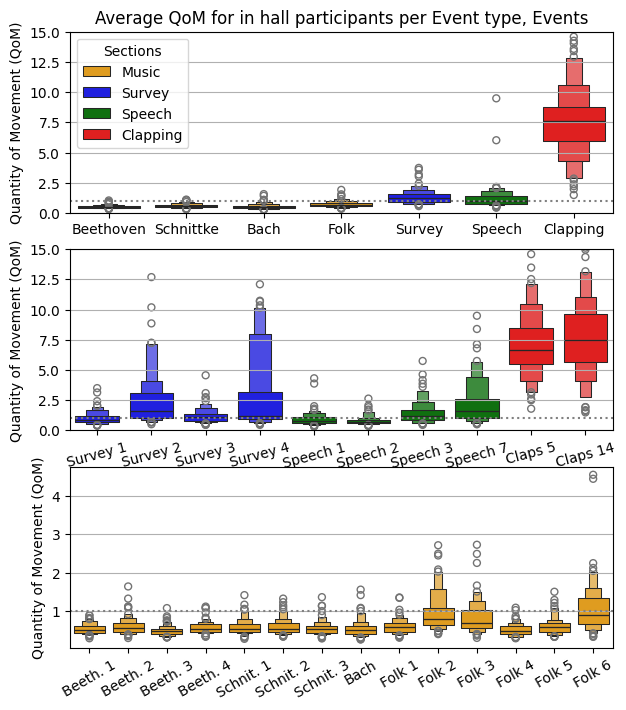

In [32]:
# sns.set_style('whitegrid')
plt.figure(figsize=(7, 8)) #, dpi=90
 
event_palette = {'Music':'orange','Survey':'blue', 'Speech':'green','Clapping':'red'}
plt.subplot(3, 1, 1)
ax = sns.boxenplot(data=res1, x='Event', y='Quantity of Movement (QoM)', hue =  'Sections',showfliers = True, palette=event_palette)
ax.set(xlabel=None)
plt.xticks(rotation=0)
plt.axhline(y=1, color='gray', linestyle=':')
ax.grid(axis='y')
ax.set_ylim([0,15])
ax.set_title('Average QoM for in hall participants per Event type, Events')

plt.subplot(3, 1, 2)
ax=sns.boxenplot(data=res3, x='Event', y='Quantity of Movement (QoM)', order = musord, hue =  'Sections', showfliers = True,legend = False,  palette=event_palette)
ax.set(xlabel=None)
plt.xticks(rotation=15)
plt.axhline(y=1, color='gray', linestyle=':')
ax.set_ylim([0,15])
ax.grid(axis='y')
#
plt.subplot(3, 1, 3)
ax=sns.boxenplot(data=res2, x='Event', y='Quantity of Movement (QoM)', hue = 'Sections', showfliers = True, legend = False, palette=event_palette)
ax.set(xlabel=None)
plt.xticks(rotation=30)
plt.axhline(y=1, color='gray', linestyle=':')
ax.grid(axis='y')
ax.set_xlim([0.5,14.5])
# plt.tight_layout()
# plt.savefig('plots/Figure_mix_qom',dpi = 196)
plt.savefig('./plots/Figure_QoM_Means.png', bbox_inches = 'tight',dpi = 196)

#
plt.show()

In [33]:
tag_m = 'Quantity of Movement (QoM)'
tag_Q = 'Event'
res1[tag_m] = res1[tag_m].astype(float)
aov = pg.rm_anova(data=res1,dv=tag_m,subject='index',within = tag_Q,effsize='ng2')
ac = pg.pairwise_tests(data=res1,dv=tag_m,subject='index',within = tag_Q,padjust = 'bonf',effsize='eta-square')#,effsize='cohen')

aov.to_csv('_'.join(['./outdata/ANOVAs/QoM_RepeatedMeasures_ANOVA_Event_Type.csv']))
print(aov.round(4))
# print(aov.loc[:,['Source', 'ddof1',  'ddof2', 'F', 'p-unc','p-GG-corr','ng2']].to_latex(index=False))

ac.to_csv('_'.join(['./outdata/ANOVAs/QoM_pairwise_Event_Type.csv']))
print(ac.round(4))
# print(ac.loc[:,['A', 'B', 'Paired', 'T', 'dof', 'p-corr', 'eta-square']].round(4).to_latex(index=False))


  Source  ddof1  ddof2         F  p-unc  p-GG-corr     ng2     eps  \
0  Event      6    420  377.2827    0.0        0.0  0.8175  0.1995   

   sphericity  W-spher  p-spher  
0       False      0.0      0.0  
   Contrast          A          B  Paired  Parametric        T   dof  \
0     Event       Bach  Beethoven    True        True  -0.3976  70.0   
1     Event       Bach   Clapping    True        True -20.9654  70.0   
2     Event       Bach       Folk    True        True  -7.2890  70.0   
3     Event       Bach  Schnittke    True        True  -2.1332  70.0   
4     Event       Bach     Speech    True        True  -8.1553  70.0   
5     Event       Bach     Survey    True        True -11.2658  70.0   
6     Event  Beethoven   Clapping    True        True -21.0108  70.0   
7     Event  Beethoven       Folk    True        True  -7.4635  70.0   
8     Event  Beethoven  Schnittke    True        True  -1.6017  70.0   
9     Event  Beethoven     Speech    True        True  -7.9526  70.0   

In [34]:
res3
tag_m = 'Quantity of Movement (QoM)'
tag_Q = 'Event'
res3[tag_m] = res3[tag_m].astype(float)
aov = pg.rm_anova(data=res3,dv=tag_m,subject='index',within = tag_Q,effsize='ng2')
ac = pg.pairwise_tests(data=res3,dv=tag_m,subject='index',within = tag_Q,padjust = 'bonf',effsize='eta-square')#,effsize='cohen')
print(ac.round(4))
print(ac.loc[ac['p-corr']<0.001,:])

aov.to_csv('_'.join(['./outdata/ANOVAs/QoM_RepeatedMeasures_ANOVA_Event_nonMusic.csv']))
print(aov.round(4))
# print(aov.loc[:,['Source', 'ddof1',  'ddof2', 'F', 'p-unc','p-GG-corr','ng2']].to_latex(index=False))

ac.to_csv('_'.join(['./outdata/ANOVAs/QoM_pairwise_Event_nonMusic.csv']))
print(ac.round(4))
# print(ac.loc[:,['A', 'B', 'Paired', 'T', 'dof', 'p-corr', 'eta-square']].round(4).to_latex(index=False))


   Contrast         A         B  Paired  Parametric        T   dof  \
0     Event  Claps 14   Claps 5    True        True   2.4540  52.0   
1     Event  Claps 14  Speech 1    True        True  15.1928  52.0   
2     Event  Claps 14  Speech 2    True        True  15.7543  52.0   
3     Event  Claps 14  Speech 3    True        True  13.9462  52.0   
4     Event  Claps 14  Speech 7    True        True  13.2382  52.0   
5     Event  Claps 14  Survey 1    True        True  15.4565  52.0   
6     Event  Claps 14  Survey 2    True        True   9.4599  52.0   
7     Event  Claps 14  Survey 3    True        True  15.2906  52.0   
8     Event  Claps 14  Survey 4    True        True   9.5114  52.0   
9     Event   Claps 5  Speech 1    True        True  14.7069  52.0   
10    Event   Claps 5  Speech 2    True        True  15.3023  52.0   
11    Event   Claps 5  Speech 3    True        True  13.3984  52.0   
12    Event   Claps 5  Speech 7    True        True  11.9458  52.0   
13    Event   Claps 

In [35]:
res2
tag_m = 'Quantity of Movement (QoM)'
tag_Q = 'Event'
res2[tag_m] = res2[tag_m].astype(float)
aov = pg.rm_anova(data=res2,dv=tag_m,subject='index',within = tag_Q,effsize='ng2')
ac = pg.pairwise_tests(data=res2,dv=tag_m,subject='index',within = tag_Q,padjust = 'bonf',effsize='eta-square')#,effsize='cohen')
print(ac.round(4))
print(ac.loc[ac['p-corr']<0.001,:])

aov.to_csv('_'.join(['./outdata/ANOVAs/QoM_RepeatedMeasures_ANOVA_Event_Music.csv']))
print(aov.round(4))
# print(aov.loc[:,['Source', 'ddof1',  'ddof2', 'F', 'p-unc','p-GG-corr','ng2']].to_latex(index=False))

ac.to_csv('_'.join(['./outdata/ANOVAs/QoM_pairwise_Event_Music.csv']))
print(ac.round(4))
# print(ac.loc[:,['A', 'B', 'Paired', 'T', 'dof', 'p-corr', 'eta-square']].round(4).to_latex(index=False))


   Contrast          A          B  Paired  Parametric       T   dof  \
0     Event       Bach   Beeth. 1    True        True -0.3820  65.0   
1     Event       Bach   Beeth. 2    True        True -2.9427  65.0   
2     Event       Bach   Beeth. 3    True        True  3.1724  65.0   
3     Event       Bach   Beeth. 4    True        True -2.3032  65.0   
4     Event       Bach     Folk 1    True        True -3.6584  65.0   
..      ...        ...        ...     ...         ...     ...   ...   
86    Event     Folk 6  Schnit. 2    True        True  7.1150  65.0   
87    Event     Folk 6  Schnit. 3    True        True  7.1278  65.0   
88    Event  Schnit. 1  Schnit. 2    True        True -0.1918  65.0   
89    Event  Schnit. 1  Schnit. 3    True        True  2.1925  65.0   
90    Event  Schnit. 2  Schnit. 3    True        True  1.8333  65.0   

   alternative   p-unc  p-corr p-adjust       BF10  eta-square  
0    two-sided  0.7037  1.0000     bonf      0.145      0.0005  
1    two-sided  0

In [40]:
palette="dark:orange"

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

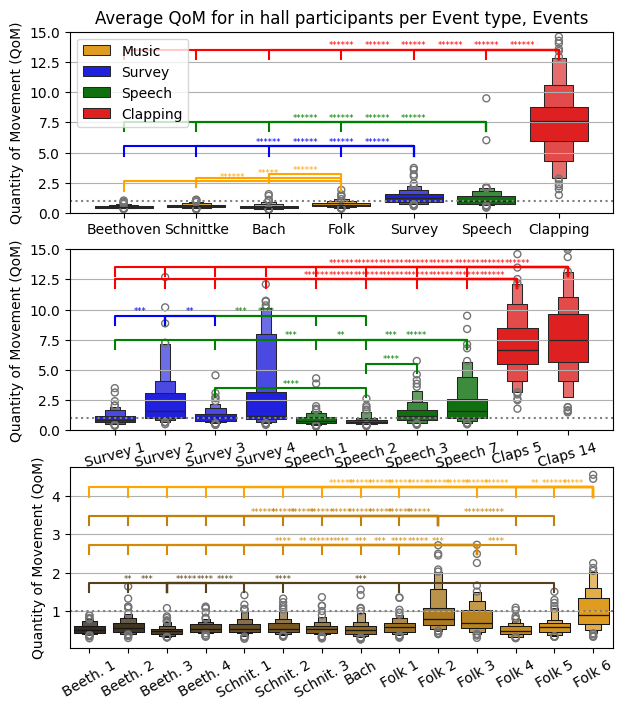

In [41]:
# sns.set_style('whitegrid')
plt.figure(figsize=(7, 8)) #, dpi=90
 
event_palette = {'Music':'orange','Survey':'blue', 'Speech':'green','Clapping':'red'}
response_order = ['Beethoven', 'Schnittke', 'Bach', 'Folk', 'Survey', 'Speech','Clapping']
plt.subplot(3, 1, 1)
ax = sns.boxenplot(data=res1, x='Event', y='Quantity of Movement (QoM)', hue =  'Sections',showfliers = True, palette=event_palette)
ax.set(xlabel=None)
ax.legend(loc='upper left')
plt.xticks(rotation=0)
plt.axhline(y=1, color='gray', linestyle=':')
ax.grid(axis='y')
ax.set_ylim([0,15])
ax.set_title('Average QoM for in hall participants per Event type, Events')

tag_m = 'Quantity of Movement (QoM)'
tag_Q = 'Event'
res1[tag_m] = res1[tag_m].astype(float)
aov = pg.rm_anova(data=res1,dv=tag_m,subject='index',within = tag_Q,effsize='ng2')
ac = pg.pairwise_tests(data=res1,dv=tag_m,subject='index',within = tag_Q,padjust = 'bonf',effsize='eta-square')#,effsize='cohen')
ls = pd.Series(response_order)
for i,row in ac.iterrows():
    if row['p-corr']<0.005:
        bc = 'k'
        if 'Folk' in row[['A','B']].values: bc = event_palette['Music']
        if 'Survey' in row[['A','B']].values: bc = event_palette['Survey']
        if 'Speech' in row[['A','B']].values: bc = event_palette['Speech']
        if 'Clapping' in row[['A','B']].values: bc = event_palette['Clapping']
        am.barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], row['p-corr'],[0,1,2,3,4,5,6], [1.1,1.4,1.7,1,4,6,12],c = bc, yerr=None, dh=.05, barh=.05, fs=6, maxasterix=6)


plt.subplot(3, 1, 2)
ax=sns.boxenplot(data=res3, x='Event', y='Quantity of Movement (QoM)', order = musord, hue =  'Sections', showfliers = True,legend = False,  palette=event_palette)
ax.set(xlabel=None)
plt.xticks(rotation=15)
plt.axhline(y=1, color='gray', linestyle=':')
ax.set_ylim([0,15])
ax.grid(axis='y')
response_order = ['Survey 1', 'Survey 2', 'Survey 3', 'Survey 4', 'Speech 1',
       'Speech 2', 'Speech 3', 'Speech 7', 'Claps 5', 'Claps 14']
res3[tag_m] = res3[tag_m].astype(float)
aov = pg.rm_anova(data=res1,dv=tag_m,subject='index',within = tag_Q,effsize='ng2')
ac = pg.pairwise_tests(data=res3,dv=tag_m,subject='index',within = tag_Q,padjust = 'bonf',effsize='eta-square')#,effsize='cohen')
ls = pd.Series(response_order)
for i,row in ac.iterrows():
    if row['p-corr']<0.005:
        bc = 'k'
        if row['A'].startswith('Sur') or row['B'].startswith('Sur'): bc = event_palette['Survey']
        if row['A'].startswith('Spe') or row['B'].startswith('Spe'): bc = event_palette['Speech']
        if row['A'].startswith('Clap') or row['B'].startswith('Clap'): bc = event_palette['Clapping']
        am.barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], row['p-corr'],np.arange(10),[2., 8., 2., 10., 2., 2, 4, 6., 11., 12.],c = bc, yerr=None, dh=.05, barh=.05, fs=6, maxasterix=6)


#
plt.subplot(3, 1, 3)
response_order = ['Music','Beeth. 1', 'Beeth. 2', 'Beeth. 3', 'Beeth. 4',
       'Schnit. 1', 'Schnit. 2', 'Schnit. 3', 'Bach', 'Folk 1', 'Folk 2',
       'Folk 3', 'Folk 4', 'Folk 5', 'Folk 6']
cp = sns.color_palette("dark:orange", len(response_order))
event_palette = dict(zip(response_order, cp))

ax=sns.boxenplot(data=res2, x='Event', y='Quantity of Movement (QoM)', hue = 'Event', showfliers = True, legend = False, palette=event_palette)
ax.set(xlabel=None)
plt.xticks(rotation=30)
plt.axhline(y=1, color='gray', linestyle=':')
ax.grid(axis='y')
ax.set_xlim([0.5,14.5])
response_order = ['Beeth. 1', 'Beeth. 2', 'Beeth. 3', 'Beeth. 4',
       'Schnit. 1', 'Schnit. 2', 'Schnit. 3', 'Bach', 'Folk 1', 'Folk 2',
       'Folk 3', 'Folk 4', 'Folk 5', 'Folk 6']
res2[tag_m] = res2[tag_m].astype(float)
aov = pg.rm_anova(data=res2,dv=tag_m,subject='index',within = tag_Q,effsize='ng2')
ac = pg.pairwise_tests(data=res2,dv=tag_m,subject='index',within = tag_Q,padjust = 'bonf',effsize='eta-square')#,effsize='cohen')
# print(ac.round(4))
# ac = pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_Hall)
ls = pd.Series(response_order)
for i,row in ac.iterrows():
    if row['p-corr']<0.005:
        bc = 'k'
        if 'Beeth. 3' in row[['A','B']].values: bc = event_palette['Beeth. 3' ]
        if 'Folk 2' in row[['A','B']].values: bc = event_palette['Folk 2']
        if 'Folk 3' in row[['A','B']].values: bc = event_palette['Folk 3']
        if 'Folk 6' in row[['A','B']].values: bc = event_palette['Folk 6']

        am.barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0],row['p-corr'],np.arange(14)+1,[1.25,1.25,1.25, 1.25,1.25, 1.25,1.25,1.25, 1.25, 3.0, 2.25,1.25, 1.25, 3.75],c = bc, yerr=None, dh=.05, barh=.05, fs=6, maxasterix=6)


# plt.tight_layout()
# plt.savefig('plots/Figure_mix_qom',dpi = 196)
plt.savefig('./plots/Figure_QoM_Means_tests.png', bbox_inches = 'tight',dpi = 196)

#
plt.show()